In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
include("../src/unit_commitments.jl")
include("../src/network_analysis.jl")
include("../src/plots.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [ ]:
# A spring day
n=100
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time):(final_time)

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]
gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]
uc_solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  2s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

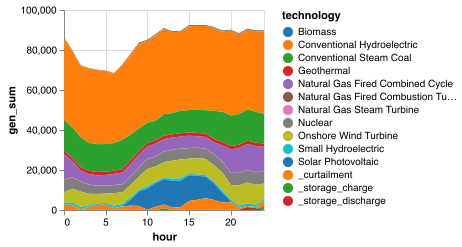

In [18]:
sol_gen = plot_total_generation(
    uc_solution, T_period,
    gen_df, zone_dict,
    "Generation with RUC Interruption at Hour "
    );

In [4]:
gen_var_actuals = copy(gen_var_multi)
gen_var_actuals.cf .= gen_var_actuals.cf .* (0.95 .+ 0.1 .* rand(nrow(gen_var_actuals)))

5200-element Vector{Float64}:
 0.9886001380021783
 1.042912245866395
 0.9998435192918906
 0.99298338803226
 1.0310114686748408
 0.9883064545263449
 1.0241504054316815
 1.0350007165047705
 0.9696747090897535
 1.0187747031079104
 1.0469467144795512
 0.9933375464289543
 0.9911466080507672
 ⋮
 0.37615451348995077
 0.38568087889976466
 0.3813135663249264
 0.3727736291634691
 0.36870697978995703
 0.37168791318010336
 0.37864575011254015
 0.38710388493966524
 0.38969600724771675
 0.3723793871979652
 0.3866919300359174
 0.37082381312983254

In [12]:
function evaluate_commitment_on_actuals(
    uc_solution,
    gen_df,
    loads_actual,
    gen_var_actual,
    network,
    mip_gap
)
    """
    Fix commitment decisions from day-ahead UC, 
    re-dispatch generation/storage/reserves against actual conditions
    """
    
    UC = Model(HiGHS.Optimizer)
    set_optimizer_attribute(UC, "mip_rel_gap", mip_gap)
    
    # Same setup as your UC model
    storage_df = gen_df[gen_df.stor .== 1, :]
    gen_df_clean = gen_df[gen_df.stor .== 0, :]
    
    G_thermal = gen_df_clean[gen_df_clean[!,:up_time] .> 0,:r_id]
    G_nonthermal = gen_df_clean[gen_df_clean[!,:up_time] .== 0,:r_id]       
    G_var = gen_df_clean[gen_df_clean[!,:vre] .== 1, :r_id]
    G_nonvar = gen_df_clean[gen_df_clean[!,:vre] .== 0,:r_id]
    G_nt_nonvar = intersect(G_nonvar, G_nonthermal)
    B = storage_df.r_id
    G = gen_df_clean.r_id
    L = network.network_lines
    T = unique(loads_actual.hour)
    T_red = T[1:end-1]
    Z = unique(gen_df_clean.zone)
    
    # Define all variables
    @variables(UC, begin
        GEN[i in G, t in T] >= 0
        GENAUX[i in G_thermal, t in T] >= 0
        CHARGE[b in B, t in T] >= 0
        DISCHARGE[b in B, t in T] >= 0
        SOC[b in B, t in T] >= 0
        FLOW[l in L, t in T]
        RESUP[i in G_thermal, t in T] >= 0
        RESDN[i in G_thermal, t in T] >= 0
        # Load shedding as slack variable
        LOADSHED[z in Z, t in T] >= 0
    end)
    
    # **KEY: Fix commitment from day-ahead solution**
    @variable(UC, COMMIT[i in G_thermal, t in T], Bin)
    
    # Extract commitment values - handle column naming
    commit_df = uc_solution.commit
    for i in G_thermal
        commit_row = commit_df[commit_df.r_id .== i, :]
        if nrow(commit_row) > 0
            for t in T
                # Try different column name formats
                col_name = nothing
                for possible_name in [Symbol("t$t"), Symbol("$t"), Symbol("T$t")]
                    if possible_name in names(commit_row)
                        col_name = possible_name
                        break
                    end
                end
                
                if !isnothing(col_name)
                    fix(COMMIT[i, t], commit_row[1, col_name]; force=true)
                else
                    @warn "Could not find column for time $t, defaulting to 0"
                    fix(COMMIT[i, t], 0.0; force=true)
                end
            end
        end
    end
    
    # Objective: minimize redispatch cost + load shedding penalty
    @objective(UC, Min,
        sum(gen_df_clean[gen_df_clean.r_id .== i, :var_cost][1] * GEN[i, t] 
            for i in G, t in T) +
        sum(gen_df_clean[gen_df_clean.r_id .== i, :start_cost][1] * 0  # START fixed
            for i in G_thermal, t in T) +
        sum(10000 * LOADSHED[z, t] for z in Z, t in T)
    )
    
    # Network balance with load shedding
    @constraint(UC, NodalBalance[z in Z, t in T],
        sum(GEN[i, t] for i in G if gen_df_clean[gen_df_clean.r_id .== i, :zone][1] == z) +
        sum(DISCHARGE[b, t] - CHARGE[b, t] for b in B if storage_df[storage_df.r_id .== b, :zone][1] == z) +
        LOADSHED[z, t] -
        loads_actual[loads_actual.zone .== z .&& loads_actual.hour .== t, :load_mw][1] -
        sum(network[l, Symbol("z$z")] * FLOW[l, t] for l in L) == 0
    )
    
    # Line flow limits
    @constraint(UC, FlowMax[l in L, t in T],
        FLOW[l, t] <= network[l, :lines_cap_mw]
    )
    @constraint(UC, FlowMin[l in L, t in T],
        FLOW[l, t] >= -network[l, :lines_cap_mw]
    )
    
    # Thermal capacity limits (respecting fixed commitment)
    @constraint(UC, Cap_thermal_min[i in G_thermal, t in T],
        GEN[i, t] >= gen_df_clean[gen_df_clean.r_id .== i, :min_power][1] * 
                     gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1] * COMMIT[i, t]
    )
    @constraint(UC, Cap_thermal_max[i in G_thermal, t in T],
        GEN[i, t] <= gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1] * COMMIT[i, t]
    )
    
    # Non-thermal non-variable capacity
    @constraint(UC, Cap_nt_nonvar[i in G_nt_nonvar, t in T],
        GEN[i, t] <= gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    
    # Variable generation using ACTUAL capacity factors
    @constraint(UC, Cap_var[i in G_var, t in T],
        GEN[i, t] <= gen_var_actual[(gen_var_actual.r_id .== i) .& (gen_var_actual.hour .== t), :cf][1] * 
                     gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    
    # Battery constraints
    @constraint(UC, ChargeCap[b in B, t in T],
        CHARGE[b, t] <= storage_df[storage_df.r_id .== b, :existing_cap_mw][1]
    )
    @constraint(UC, DischargeCap[b in B, t in T],
        DISCHARGE[b, t] <= storage_df[storage_df.r_id .== b, :existing_cap_mw][1]
    )
    @constraint(UC, SOCCap[b in B, t in T],
        SOC[b, t] <= storage_df[storage_df.r_id .== b, :existing_cap_mwh][1]
    )
    
    @constraint(UC, cStateOfChargeEnd[b in B],
        SOC[b, T[end]] == storage_df[storage_df.r_id .== b, :existing_cap_mwh][1] * 0.5
    )
    @constraint(UC, cStateOfChargeStart[b in B],
        SOC[b, T[1]] == storage_df[storage_df.r_id .== b, :existing_cap_mwh][1] * 0.5 +
        storage_df[storage_df.r_id .== b, :eff_up][1] * CHARGE[b, T[1]] -
        DISCHARGE[b, T[1]] / storage_df[storage_df.r_id .== b, :eff_down][1]
    )
    @constraint(UC, cStateOfCharge[b in B, t in T[2:end]],
        SOC[b, t] == SOC[b, t-1] +
        storage_df[storage_df.r_id .== b, :eff_up][1] * CHARGE[b, t] -
        DISCHARGE[b, t] / storage_df[storage_df.r_id .== b, :eff_down][1]
    )
    
    # Auxiliary generation variable for ramping
    @constraint(UC, AuxGen[i in G_thermal, t in T],
        GENAUX[i, t] == GEN[i, t] - 
        gen_df_clean[gen_df_clean.r_id .== i, :min_power][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1] * COMMIT[i, t]
    )
    
    # Ramping constraints (thermal)
    @constraint(UC, RampUp_thermal[i in G_thermal, t in T_red],
        GENAUX[i, t+1] - GENAUX[i, t] <= 
        gen_df_clean[gen_df_clean.r_id .== i, :ramp_up_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    @constraint(UC, RampDn_thermal[i in G_thermal, t in T_red],
        GENAUX[i, t] - GENAUX[i, t+1] <= 
        gen_df_clean[gen_df_clean.r_id .== i, :ramp_dn_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    
    # Ramping constraints (non-thermal)
    @constraint(UC, RampUp_nonthermal[i in G_nonthermal, t in T_red],
        GEN[i, t+1] - GEN[i, t] <= 
        gen_df_clean[gen_df_clean.r_id .== i, :ramp_up_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    @constraint(UC, RampDn_nonthermal[i in G_nonthermal, t in T_red],
        GEN[i, t] - GEN[i, t+1] <= 
        gen_df_clean[gen_df_clean.r_id .== i, :ramp_dn_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    
    # Reserve constraints
    @constraint(UC, ResUpCap[i in G_thermal, t in T],
        RESUP[i, t] <= gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1] * COMMIT[i, t] - GEN[i, t]
    )
    @constraint(UC, ResDnCap[i in G_thermal, t in T],
        RESDN[i, t] <= GEN[i, t] - 
        gen_df_clean[gen_df_clean.r_id .== i, :min_power][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1] * COMMIT[i, t]
    )
    
    @constraint(UC, ResUpRamp[i in G_thermal, t in T],
        RESUP[i, t] <= gen_df_clean[gen_df_clean.r_id .== i, :ramp_up_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    @constraint(UC, ResDnRamp[i in G_thermal, t in T],
        RESDN[i, t] <= gen_df_clean[gen_df_clean.r_id .== i, :ramp_dn_percentage][1] * 
        gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
    )
    
    ResReqUp = Dict(t => 300 for t in T)
    ResReqDn = Dict(t => 0 for t in T)
    
    @constraint(UC, ResUpRequirement[t in T],
        sum(RESUP[i, t] for i in G_thermal) >= ResReqUp[t]
    )
    @constraint(UC, ResDnRequirement[t in T],
        sum(RESDN[i, t] for i in G_thermal) >= ResReqDn[t]
    )
    
    optimize!(UC)
    
    # Extract results
    gen_actual = value_to_df_2dim(value.(GEN))
    loadshed = value_to_df_2dim(value.(LOADSHED))
    resup = value_to_df_2dim(value.(RESUP))
    resdn = value_to_df_2dim(value.(RESDN))
    
    # Calculate curtailment
    curtail = DataFrame(r_id = Int[], hour = Int[], curt = Float64[])
    for i in G_var
        for t in T
            available = gen_var_actual[(gen_var_actual.r_id .== i) .& (gen_var_actual.hour .== t), :cf][1] * 
                       gen_df_clean[gen_df_clean.r_id .== i, :existing_cap_mw][1]
            actual_gen = value(GEN[i, t])
            curt_val = max(0, available - actual_gen)
            push!(curtail, (i, t, curt_val))
        end
    end
    
    # Calculate total CO2 emissions
    total_co2 = sum(
        gen_df_clean[gen_df_clean.r_id .== i, :heat_rate_mmbtu_per_mwh][1] * 
        0.05306 *  # tons CO2 per MMBtu
        value(GEN[i, t]) 
        for i in G, t in T
    )
    
    # Battery results
    charge_df = value_to_df_2dim(value.(CHARGE))
    discharge_df = value_to_df_2dim(value.(DISCHARGE))
    soc_df = value_to_df_2dim(value.(SOC))
    
    return (
        model = UC,
        generation = gen_actual,
        commit = uc_solution.commit,  # Keep original commitments
        loadshed = loadshed,
        curtailment = curtail,
        reserves_up = resup,
        reserves_down = resdn,
        charge = charge_df,
        discharge = discharge_df,
        soc = soc_df,
        total_loadshed = sum(value.(LOADSHED)),
        total_curtailment = sum(curtail.curt),
        total_co2 = total_co2,
        objective = objective_value(UC)
    )
end

evaluate_commitment_on_actuals (generic function with 1 method)

In [19]:
actual_solution = evaluate_commitment_on_actuals(
    uc_solution,
    gen_df,
    loads_multi,
    gen_var_actuals,
    network,
    0.01
)

┌ Warning: Could not find column for time 2406, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2407, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2408, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2409, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2410, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2411, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2412, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2413, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2414, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2415, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2416, defaulting to 0
└ @ Main In[12]:68
┌ Warning: Could not find column for time 2417, defaulting to 0
└ @ Main In[12]:68
┌ Wa

LoadError: ArgumentError: column name :var_cost not found in the data frame

In [ ]:
# stop halfway through
recommit_time = 12
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time + recommit_time):(final_time)

loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]
ruc_gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

gen_vre = gen_df[gen_df[!,:vre] .== 1, :r_id]
mask = in.(ruc_gen_var_multi.r_id, Ref(gen_vre))
ruc_gen_var_multi[mask, :cf] .*= 1.5 # it's real sunny ! and windy !

ruc_solution = reliability_uc(
    solution.decision_vars, n*24+6 + recommit_time,
    gen_df, loads_multi, ruc_gen_var_multi, network, 0.01); #1% MIP Gap